# Introduction to normalizing flows

The corresponding presentation is here: https://docs.google.com/presentation/d/1_mPs2Voo_4qV0HYCn7XnZ0uVmeNpWphNZDtfHWSb0ug/edit?usp=sharing

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi, log
from torch.utils import data
import numpy as np
from torch import tensor
from torch.distributions import Normal
import matplotlib as mpl

In [3]:
_ = torch.manual_seed(0)

# Let's move to a simple example

In [5]:
mean = 1.0
std = 0.4

normal_dist = Normal(mean, std)  # We do not usually know this...
samples = normal_dist.sample((50,))  # ...but all we have are these samples.

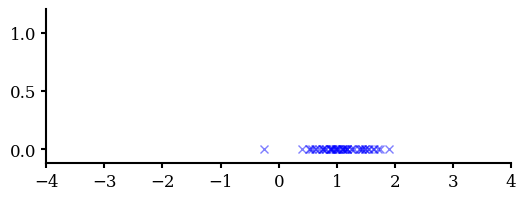

In [7]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none', markersize=6)
    _ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])

We can also find the minimum of the negative logarithm (becaus log is monotonic):

$\mu', \sigma' =  \text{argmin}_{\mu, \sigma} - \log \prod_i \mathcal{N}(\theta_i; \mu, \sigma) = \text{argmin}_{\mu, \sigma} - \sum_i \log \mathcal{N}(\theta_i; \mu, \sigma)$

In [8]:
from torch import tensor, as_tensor

In [19]:
dataset = data.TensorDataset(samples)
train_loader = data.DataLoader(samples, batch_size=10)

learned_a = torch.nn.Parameter(torch.zeros(1))
learned_b = torch.nn.Parameter(torch.ones(1))
base_dist = Normal(tensor(0.0), tensor(1.0))

opt = optim.Adam([learned_a, learned_b], lr=0.005)

def u_to_x(u, a, b):
    return a + u * b

def x_to_u(x, a, b):
    return (x - a) / b

for e in range(500):
    for sample_batch in train_loader:
        opt.zero_grad()
        
        u = x_to_u(sample_batch, learned_a, learned_b)
        p_u = torch.exp(base_dist.log_prob(u))
        derivative = learned_b
        p_x = p_u / derivative
        
        loss = -torch.log(p_x).sum()
        loss.backward() 
        opt.step()

In [22]:
u_samples = base_dist.sample((10,))
x_samples = u_to_x(u_samples, learned_a, learned_b)

In [25]:
print(torch.mean(x_samples))
print(torch.std(x_samples))

tensor(0.9375, grad_fn=<MeanBackward0>)
tensor(0.5022, grad_fn=<StdBackward>)


In [33]:
eval_x = torch.linspace(-4, 4, 100)

u = x_to_u(eval_x, learned_a, learned_b)
p_u = torch.exp(base_dist.log_prob(u))
derivative = learned_b
p_x = p_u / derivative

learned_probs = p_x

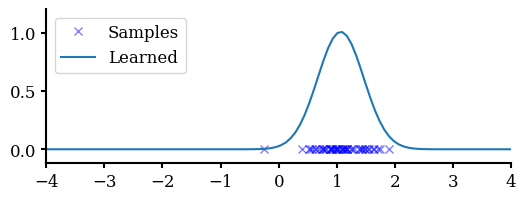

In [37]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(samples, np.zeros_like(samples), 'bx', alpha=0.5, markerfacecolor='none', markersize=6)
    plt.plot(eval_x.numpy(), learned_probs.detach().numpy())
    plt.legend(["Samples", "Learned"], loc="upper left")
    _ = plt.xlim([-4, 4]); _ = plt.ylim([-0.12, 1.2])